# CHIMERA Reference plots

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# source the nxcals python libs
from nxcals.api.extraction.data.builders import *
from datetime import datetime
from datetime import timedelta
import pickle
from matplotlib import gridspec
import seaborn as sns
import matplotlib.cm as cm

def my_mpl_style():
    '''Sets my preferred style options for matplotlib.'''
    import matplotlib as mpl
    # Font sizes
    mpl.rcParams['axes.labelsize'] = 18
    mpl.rcParams['legend.fontsize'] = 18
    mpl.rcParams['xtick.labelsize'] = 16
    mpl.rcParams['ytick.labelsize'] = 16
    mpl.rcParams['axes.formatter.limits'] = (-2, 3)
my_mpl_style()

# Intensity plots

Times series of the SEC70 intensity and related variabilty quantification

In [2]:
# Retrieving the data
# Time in UTC
start = "2022-11-23 17:40:00"
stop = "2022-11-23 22:00:00"
selector = 'CPS.USER.MD5'

spills = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(start).endTime(stop).entity().parameter("T08.XSEC070-I/SpillData").build()
df_spills = spills.filter(spills.selector==selector).toPandas()

24/06/20 13:51:51 WARN URLConfigurationSource: No URLs will be polled as dynamic configuration sources.
24/06/20 13:52:06 WARN CheckAllocator: More than one DefaultAllocationManager on classpath. Choosing first found


Text(0.5, 0, 'Time UTC')

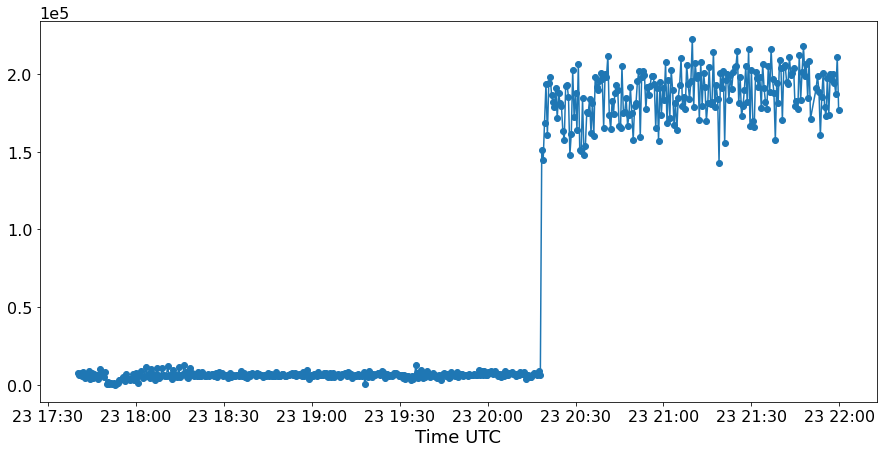

In [3]:
# Time series of the XSEC70
df_spills['timestamp'] = pd.to_datetime(df_spills['acqStamp'], unit='ns')
df_spills['intensity'] = df_spills['semSpillData'].apply(lambda x: abs(sum(x['elements'])))
df_spills_sorted = df_spills.sort_values(by='timestamp')

fig, ax = plt.subplots(figsize=(15,7))

ax.plot(df_spills_sorted.timestamp, df_spills_sorted.intensity, marker="o")
ax.set_xlabel("Time UTC")

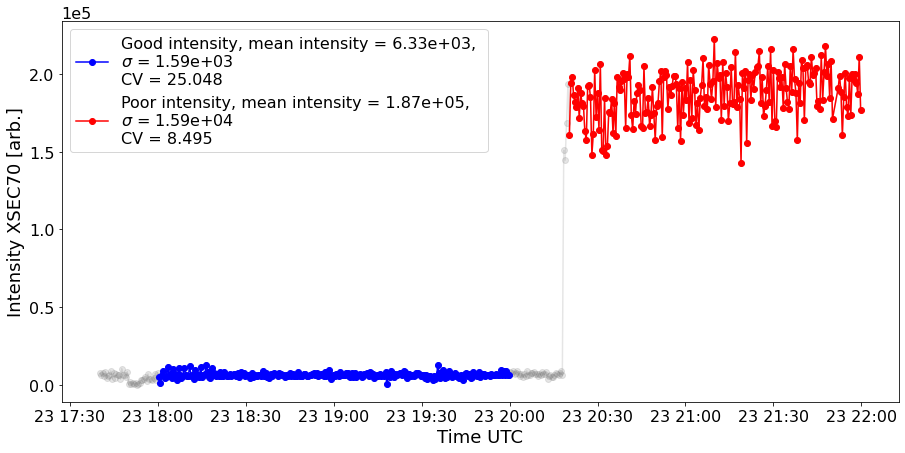

In [4]:
# Time series of the XSEC70 with related variabilty quantification
def plot_intensity(ax, df, start_time, end_time, color, label):
    df_subset = df.set_index('timestamp').between_time(start_time, end_time).reset_index()
    intensity_mean = np.mean(df_subset.intensity)
    intensity_std = np.std(df_subset.intensity)
    cv = (intensity_std / intensity_mean) * 100
    ax.plot(df_subset.timestamp, df_subset.intensity, marker="o", color=color,
            label=f"{label}, mean intensity = {'{:.2e}'.format(intensity_mean)}, \n$\sigma$ = {'{:.2e}'.format(intensity_std)} \nCV = {round(cv,3)}")

fig, ax = plt.subplots(figsize=(15, 7))

# Plot data for different time intervals
ax.plot(df_spills_sorted.timestamp, df_spills_sorted.intensity, marker="o", color="gray", alpha=0.2)
plot_intensity(ax, df_spills_sorted, '18:00', '20:00', 'blue', "Good intensity")
plot_intensity(ax, df_spills_sorted, '20:20', '22:00', 'red', "Poor intensity")


ax.legend(fontsize=16)
ax.set_xlabel("Time UTC")
ax.set_ylabel("Intensity XSEC70 [arb.]")

plt.show()


# Example of PS BCT cycle and how the extracted intensity is calculated from it, as a different between two given times in the cycle

In [5]:
ts1 = datetime(2023, 10, 19, 17, 37, 29)
ts2 = datetime(2023, 10, 20, 5, 27, 10)

funds = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(ts1).endTime(ts2).entity().parameter("XTIM.PX.SCY-CT/Acquisition").build()
funds_filtered = funds.select("acqStamp","cyclestamp", "USER", "lsaCycleName")

spills = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(ts1).endTime(ts2).entity().parameter("T08.XSEC070-I/SpillData").build()
spills_filtered = spills.select("acqStamp", "cyclestamp", "selector", "semSpillData")


gain = DevicePropertyDataQuery.builder(spark).system('CMW').startTime(ts1).endTime(ts2).entity().parameter('PR.BQL72/SummaryAcquisition').build()
gain_filtered = gain.select("acqStamp","cyclestamp", "exAmplitudeH")

bct =  DevicePropertyDataQuery.builder(spark).system("CMW").startTime(ts1).endTime(ts2).entity().parameter("PR.BCT-ST/CycleSamples").build()
bct_filtered = bct.select("acqStamp", "cyclestamp", "samples")


bfield = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(ts1).endTime(ts2).entity().parameter("PR.BMEAS-B-ST/CycleSamples").build()
bfield_filtered = bfield.select("acqStamp", "cyclestamp", "samples")

spills_xsec23 = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(ts1).endTime(ts2).entity().parameter("F61.XSEC023-I1/SpillData").build()
spills_xsec23_filtered = spills_xsec23.select("acqStamp", "cyclestamp", "selector", "semSpillData")

In [6]:
from pyspark.sql.functions import broadcast

data = spills_filtered.join(broadcast(funds_filtered), "cyclestamp")
data = data.join(broadcast(gain_filtered), "cyclestamp")
data = data.join(broadcast(bct_filtered), "cyclestamp")
data = data.join(broadcast(bfield_filtered), "cyclestamp")
data = data.join(broadcast(spills_xsec23_filtered), "cyclestamp")

data = data.toPandas()

# Print the DataFrame before renaming
data.head(3)

# Identify the index of the second 'B' column
duplicate_column_name = 'samples'
column_indices = [i for i, col in enumerate(data.columns) if col == duplicate_column_name]
second_column_index = column_indices[1]

# Rename the second 'B' column directly
data.columns.values[second_column_index] = 'samples_b_field'

# For the XSEC
# Identify the index of the second 'B' column
duplicate_column_name = 'semSpillData'
column_indices = [i for i, col in enumerate(data.columns) if col == duplicate_column_name]
second_column_index = column_indices[1]

# Rename the second 'semSpillData' column directly
data.columns.values[second_column_index] = 'semSpillData_xsec23'

# Print DataFrame after renaming
data.head(3)

cyclestamp             acqStamp        selector  \
0  1697737846300000000  1697737848091000000  CPS.USER.EAST1   
1  1697747017900000000  1697747019741000000    CPS.USER.MD3   
2  1697748808300000000  1697748810091000000    CPS.USER.MD5   

                                        semSpillData             acqStamp  \
0  {'elements': [-214, -205, 177, 328, -15, -283,...  1697737846300238525   
1  {'elements': [156, 18, -239, -20, 28, 232, -25...  1697747017900238525   
2  {'elements': [5, -17, 9, -4, -6, -1, 10, 15, -...  1697748808300238525   

    USER  lsaCycleName             acqStamp  exAmplitudeH  \
0  EAST1     EAST_N_23  1697737846471000000       0.30000   
1    MD3   IEAST_Pb_23  1697747019530000000       0.14726   
2    MD5  DEGAUSS_EAST  1697748808411000000       0.06000   

              acqStamp                                            samples  \
0  1697737846300238525  {'elements': [nan, nan, nan, nan, nan, nan, na...   
1  1697747017900238525  {'elements': [nan, nan, nan, nan, nan, nan, na...   
2  1697748808300238525  {'elements': [nan, nan, nan, nan, nan, nan, na...   

              acqStamp                                    samples_b_field  \
0  1697737848698238525  {'elements': [16.290199710056186, 16.307899495...   
1  1697747020298238525  {'elements': [-2.0106000010855496, -1.54580004...   
2  1697748810698238525  {'elements': [-14.81689978390932, -14.74219956...   

              acqStamp        selector  \
0  1697737848091000000  CPS.USER.EAST1   
1  1697747019741000000    CPS.USER.MD3   
2  1697748810091000000    CPS.USER.MD5   

                                 semSpillData_xsec23  
0  {'elements': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2...  
1  {'elements': [0, 0, -1, 0, 0, 0, 0, 0, 0, 0, -...  
2  {'elements': [0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0...

In [7]:
data['intensity'] = data['semSpillData'].apply(lambda x: abs(sum(x['elements'])))
data['intensity_xsec23'] = data['semSpillData_xsec23'].apply(lambda x: abs(sum(x['elements'])))
data['avg_flattop_Gauss'] = data['samples_b_field'].apply(lambda x: round(np.mean(x["elements"][1000:1500]), 1)) # Hardcoded flattop time
data['Ekin'] = data['avg_flattop_Gauss'].apply(lambda x: (193.737692/208)*(np.sqrt(((1/((3.3356/(70.0789*54)*10000)/x))/193.737692)**2+1)-1), 1) # Hardcoded flattop time
data["previous_lsaCycleName"] = data['lsaCycleName'].shift(1)
data["previous2_lsaCycleName"] = data['lsaCycleName'].shift(2)
data = data.loc[:, ~data.columns.duplicated()]
data['timestamp'] = pd.to_datetime(data['acqStamp'], unit='ns')

/tmp/ipykernel_5837/854590608.py:4: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  data['Ekin'] = data['avg_flattop_Gauss'].apply(lambda x: (193.737692/208)*(np.sqrt(((1/((3.3356/(70.0789*54)*10000)/x))/193.737692)**2+1)-1), 1) # Hardcoded flattop time


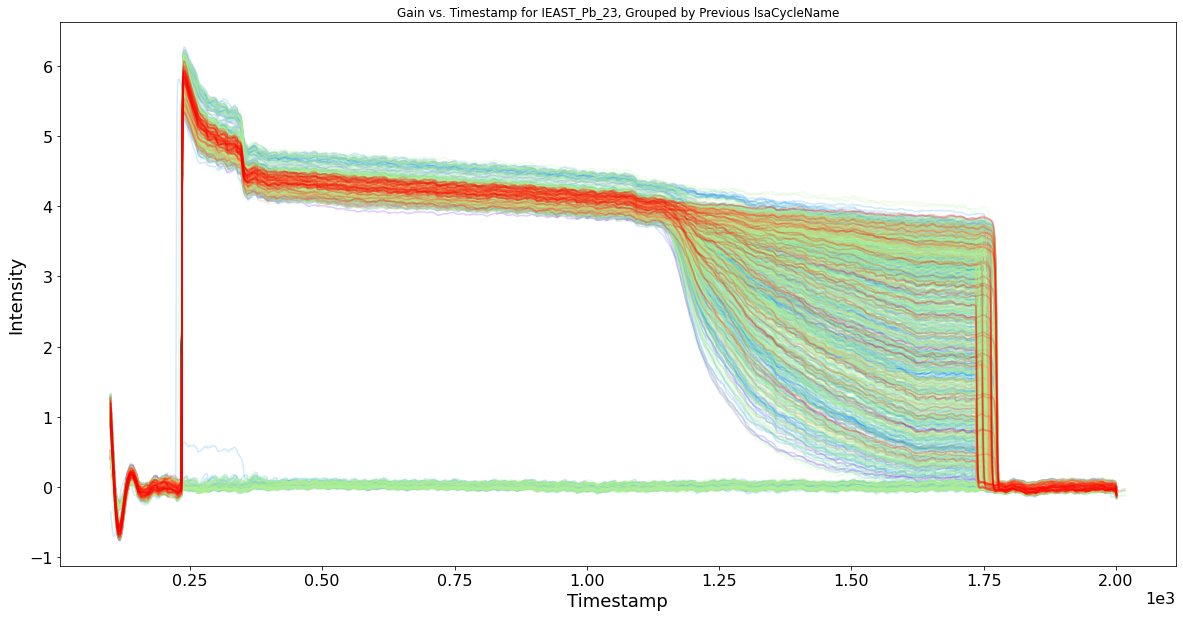

In [8]:
data_IEAST_Pb_23 = data[data['lsaCycleName'] == "IEAST_Pb_23"]
grouped = data_IEAST_Pb_23.where( (data_IEAST_Pb_23.exAmplitudeH > 0.01) & (data_IEAST_Pb_23.exAmplitudeH < 0.2)).groupby("previous_lsaCycleName")

def get_elements(row):
    return row["elements"]

# Define a color map
num_groups = len(grouped)
colors = cm.rainbow(np.linspace(0, 1, num_groups))

fig, ax = plt.subplots(figsize=(20,10))

for (name, group), color in zip(grouped, colors):
    grouped_inner = group.groupby("previous2_lsaCycleName")
    for name2, group_inner in grouped_inner:
        for elements in group_inner["samples"].apply(get_elements):
            ax.plot(elements, color=color, alpha=0.2)  # Plot with the assigned color

    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Intensity')
    ax.set_title('Gain vs. Timestamp for IEAST_Pb_23, Grouped by Previous lsaCycleName')

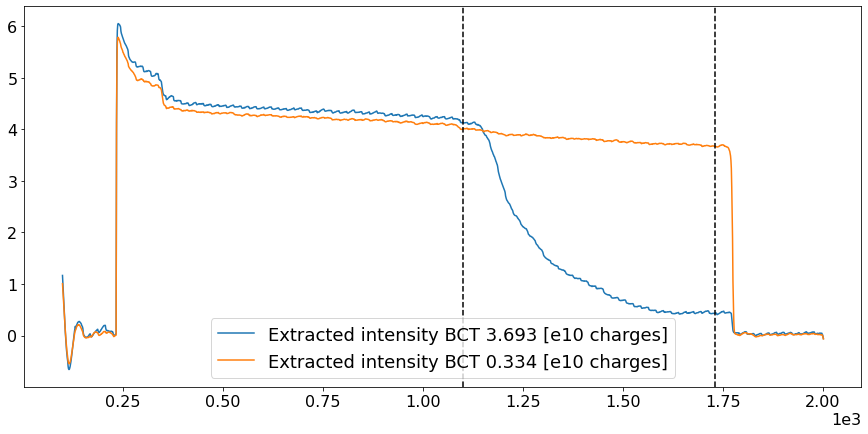

In [9]:
def get_bct_start(row):
    return row["elements"][1100]
def get_bct_end(row):
    return row["elements"][1730]

data["bct_start"] = data["samples"].apply(get_bct_start)
data["bct_end"] = data["samples"].apply(get_bct_end)
data["bct_diff"] = data["bct_start"] - data["bct_end"]
data.sort_values(by="timestamp",inplace=True)

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(data.iloc[0].samples["elements"], label=f"Extracted intensity BCT {data.iloc[0].bct_diff:.3f} [e10 charges]")
ax.plot(data.iloc[1].samples["elements"], label=f"Extracted intensity BCT {data.iloc[1].bct_diff:.3f} [e10 charges]")
ax.axvline(1100, ls="--", c="k")
ax.axvline(1730, ls="--", c="k")
ax.legend()

Text(0.5, 0, 'Timestamp')

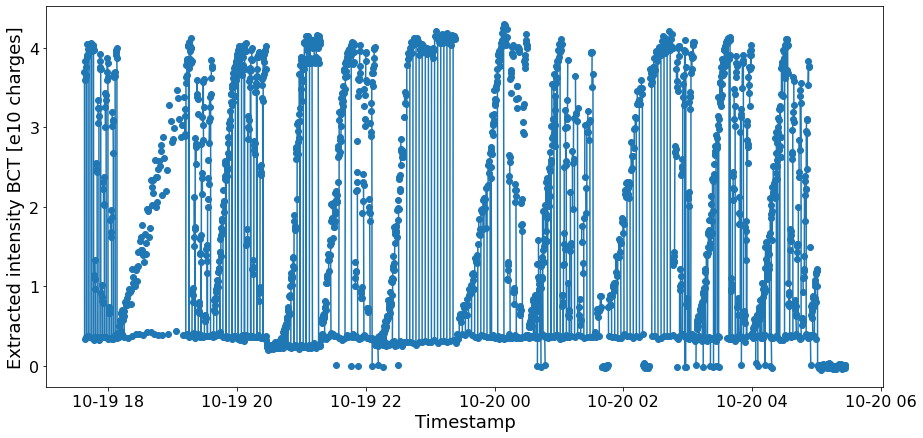

In [10]:
fig, ax = plt.subplots(figsize=(15,7))
data.sort_values(by="timestamp",inplace=True)
ax.plot(data.timestamp, data.bct_diff, marker="o")
ax.set_ylabel("Extracted intensity BCT [e10 charges]")
ax.set_xlabel("Timestamp")
# ax.set_yscale("log")

# Relationship between the three main intensity variables: PS BCT, SEC23, SEC70, XION70

Text(0, 0.5, 'XSEC23 intensity [arb.]')

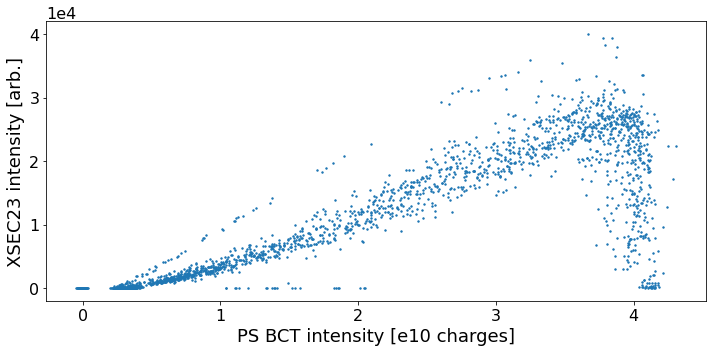

In [11]:
fig, ax = plt.subplots(tight_layout=True, figsize=(10,5))
ax.scatter(data["bct_diff"], data["intensity_xsec23"], s=2)
ax.set_xlabel("PS BCT intensity [e10 charges]")
ax.set_ylabel("XSEC23 intensity [arb.]")

# MWPC Profile and Gaussian fit

In [12]:
# Time in UTC
start = "2023-10-28 18:00:00.000"
end = "2023-10-29 00:01:00.000"
selector = "CPS.USER.MD3"

data = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(start).endTime(end).entity().parameter("BXMWPC_2080/Acquisition").build().toPandas()
data["timestamp"] = pd.to_datetime(data['acqStamp'], unit='ns')

24/06/20 13:55:13 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [13]:
def gaussian_function(x, a, I, mu, sig):
    return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)

def do_gaussian_fit(x,y):
    mu = np.average(x, weights=np.abs(y - np.min(y)))
    sigma = np.sqrt(np.average(x**2, weights=np.abs(y - np.min(y))) - mu**2)
    p0 = [y.min(), (np.max(y) - np.min(y)) * np.sqrt(2 * np.pi * sigma**2), mu, sigma]
    popt, pcov = curve_fit(gaussian_function, x, y, p0=p0, maxfev=1000) # maxfev is the number of tries it does the fit
    return popt, pcov

def fwhm_func(sigma):
        return abs(2 * np.sqrt(2 * np.log(2)) * sigma)

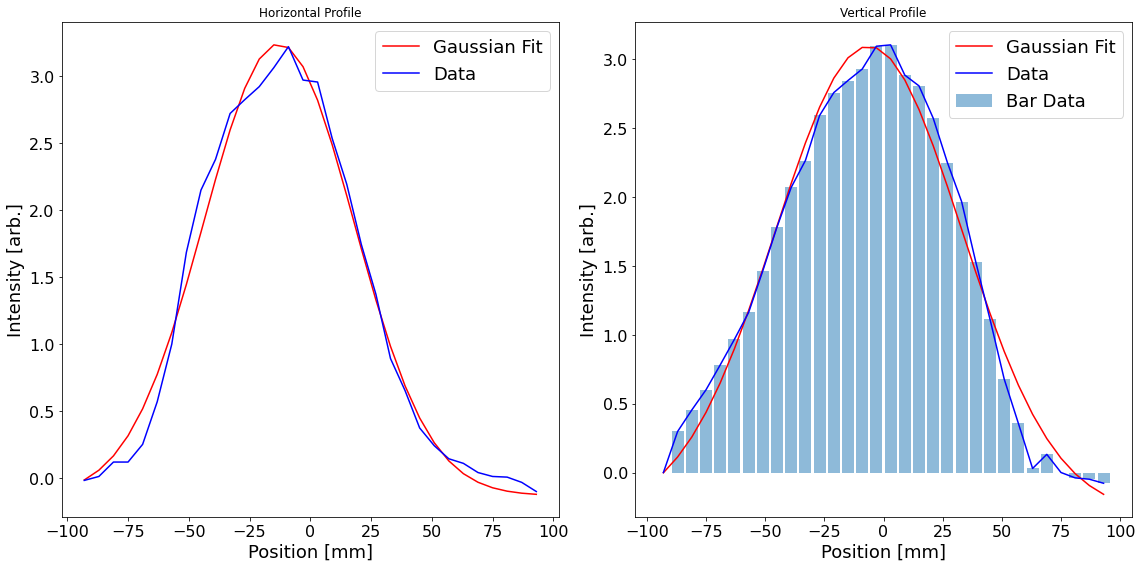

In [14]:
from scipy.optimize import curve_fit

# Sort data by timestamp
data.sort_values(by="timestamp", inplace=True)

# Create subplots with specific layout and figure size
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(16, 8))

# Generate x-axis values for the profile data
x = np.linspace(93, -93, num=32)
MWPC_wire = np.linspace(93, -93, num=32)

# Initialize lists to store timestamps and FWHM values
timestamp_list = []
fwhm_list = []
timestamp_listV = []
fwhm_listV = []

# Select the profile data for horizontal fit
y = data[data.selector == selector].profileHoriz.iloc[0]["elements"][0:32]

# Perform Gaussian fit for horizontal profile
popt, pcov = do_gaussian_fit(x, y)
perrH = np.sqrt(np.diag(pcov))

# Check if the fit is acceptable
if perrH[2] < 1:
    ax[0].plot(x, gaussian_function(x, popt[0], popt[1], popt[2], popt[3]), c="r", label='Gaussian Fit')
    ax[0].plot(x, y, c="b", label='Data')
    ax[0].set_title('Horizontal Profile')
    ax[0].set_xlabel('Position [mm]')
    ax[0].set_ylabel('Intensity [arb.]')
    ax[0].legend()

    fwhm = abs(fwhm_func(popt[2]))
    timestamp = data[data.selector == selector].timestamp.iloc[0]

    timestamp_list.append(timestamp)
    fwhm_list.append(fwhm)

# Select the profile data for vertical fit
yV = data[data.selector == selector].profileVert.iloc[0]["elements"][0:32]

# Perform Gaussian fit for vertical profile
poptV, pcovV = do_gaussian_fit(x, yV)
perrV = np.sqrt(np.diag(pcovV))

# Check if the fit is acceptable
if perrV[2] < 1:
    ax[1].plot(x, gaussian_function(x, poptV[0], poptV[1], poptV[2], poptV[3]), c="r", label='Gaussian Fit')
    ax[1].plot(x, yV, c="b", label='Data')
    ax[1].bar(x, yV, width=5, alpha=0.5, label='Bar Data')
    ax[1].set_title('Vertical Profile')
    ax[1].set_xlabel('Position [mm]')
    ax[1].set_ylabel('Intensity [arb.]')
    ax[1].legend()

    fwhmV = abs(fwhm_func(poptV[3]))
    timestampV = data[data.selector == selector].timestamp.iloc[0]

    timestamp_listV.append(timestampV)
    fwhm_listV.append(fwhmV)

# Show the plot
plt.show()


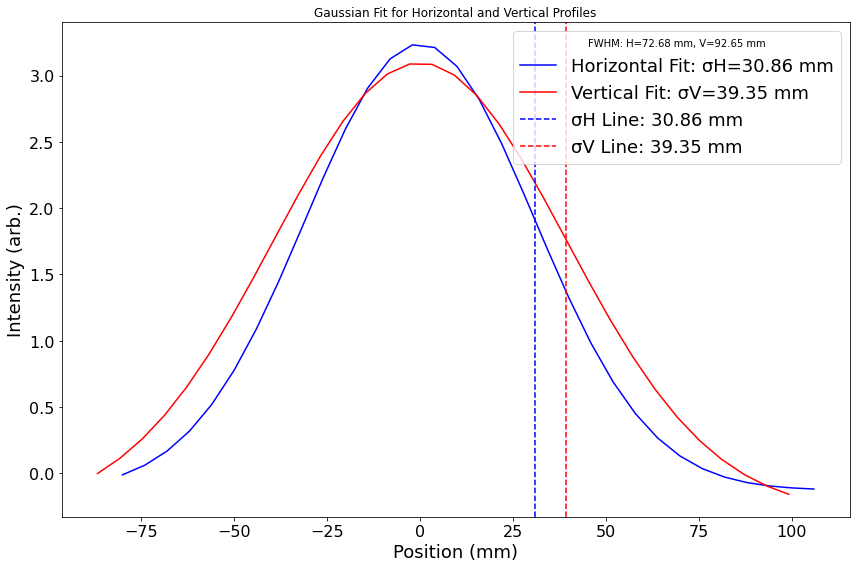

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Generate x-axis values for the profile data
x = np.linspace(93, -93, num=32)
MWPC_wire = np.linspace(93, -93, num=32)

# Create subplots with specific layout and figure size
fig, ax = plt.subplots(1, tight_layout=True, figsize=(12, 8))

# Initialize lists to store timestamps and FWHM values
timestamp_list = []
fwhm_list = []
timestamp_listV = []
fwhm_listV = []

# Assuming popt and poptV are already defined from previous Gaussian fits
muH = popt[2]
muV = poptV[2]
sigmaH = np.abs(popt[3])
sigmaV = np.abs(poptV[3])

# Plot Gaussian fits for horizontal and vertical profiles
ax.plot(x - muH, gaussian_function(x, popt[0], popt[1], popt[2], popt[3]), c="b", label=f'Horizontal Fit: σH={sigmaH:.2f} mm')
ax.plot(x - muV, gaussian_function(x, poptV[0], poptV[1], poptV[2], poptV[3]), c="r", label=f'Vertical Fit: σV={sigmaV:.2f} mm')

# Plot vertical lines indicating the sigma values
ax.axvline(sigmaH, c="b", linestyle='--', label=f'σH Line: {sigmaH:.2f} mm')
ax.axvline(sigmaV, c="r", linestyle='--', label=f'σV Line: {sigmaV:.2f} mm')

# Calculate FWHM values and add to legend
fwhmH = 2 * np.sqrt(2 * np.log(2)) * sigmaH
fwhmV = 2 * np.sqrt(2 * np.log(2)) * sigmaV

# Add labels and title
ax.set_title('Gaussian Fit for Horizontal and Vertical Profiles')
ax.set_xlabel('Position (mm)')
ax.set_ylabel('Intensity (arb.)')
ax.legend(title=f'FWHM: H={fwhmH:.2f} mm, V={fwhmV:.2f} mm')

# Show the plot
plt.show()


/tmp/ipykernel_5837/1313969936.py:66: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 11


Text(0.5, 0.98, 'MWPC at 18:12:08\n28/10/2023')

/cvmfs/sft.cern.ch/lcg/views/LCG_105a_nxcals_pro/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


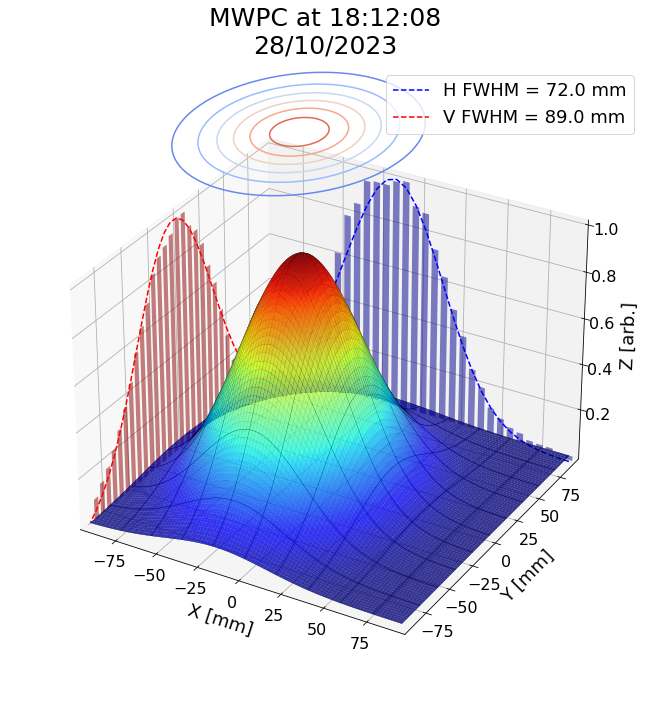

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy.stats import multivariate_normal

fig = plt.figure(figsize=(30, 10), tight_layout=True)
ax = fig.add_subplot(projection='3d',computed_zorder=False)

target_timestamp = pd.to_datetime('2023-10-28 18:12:00.00')
differences = (data[data.selector == selector].timestamp - target_timestamp).abs()
closest_index = differences.idxmin()
element = closest_index
MWPC_wire = np.linspace(93, -93, num=32)


data[data.selector == selector].timestamp.loc[element]

# Horizontal Measurement and Gaussian Fit
y = data[data.selector == selector].profileHoriz.loc[element]["elements"][0:32]
ax.bar(MWPC_wire, y/y.max(), zs=MWPC_wire.max(), width=4, zdir='y', color="darkblue", alpha=0.5)

popt, pcov = do_gaussian_fit(MWPC_wire, y)
y_gaussian = gaussian_function(MWPC_wire, popt[0], popt[1], popt[2], popt[3])
ax.plot(xs=MWPC_wire, ys=np.ones(len(MWPC_wire))*MWPC_wire.max(), zs=y_gaussian/y_gaussian.max(), zdir='z', c="b", ls="dashed", label=f"H FWHM = {fwhm_func(popt[3]):.1f} mm")

# Vertical Measurement and Gaussian Fit
y = data[data.selector == selector].profileVert.loc[element]["elements"][0:32]
ax.bar(MWPC_wire, y/y.max(), zs=MWPC_wire.min(), width=4, zdir='x', color="darkred", alpha=0.5)
poptV, pcovV = do_gaussian_fit(MWPC_wire, y)
y_gaussian = gaussian_function(MWPC_wire, poptV[0], poptV[1], poptV[2], poptV[3])
ax.plot(xs=np.ones(len(MWPC_wire))*MWPC_wire.min(), ys=MWPC_wire, zs=y_gaussian/y_gaussian.max(), zdir='z', c="r", ls="dashed", label=f"V FWHM = {fwhm_func(poptV[3]):.1f} mm")


# Set mean and covariance matrix for the multivariate Gaussian
mean = [popt[2], poptV[2]]
covariance_matrix = [[popt[3]**2, 0], [0, poptV[3]**2]]

# Create a grid of points
x = np.linspace(MWPC_wire.min(), MWPC_wire.max(), 100)
y = np.linspace(MWPC_wire.min(), MWPC_wire.max(), 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

# Create a multivariate Gaussian distribution
mvn = multivariate_normal(mean, covariance_matrix)

# Evaluate the PDF values for each point in the grid
Z = mvn.pdf(pos)
Z=Z/Z.max() # Normalize

# Plot the 3D surface
ax.plot_surface(X, Y, Z, edgecolor='k', lw=0.05, rstride=1, cstride=1, cmap="jet", zorder=99, alpha=0.8)
ax.plot_surface(X, Y, Z, edgecolor='k', lw=0.3, rstride=10, cstride=10, zorder=98, alpha=0.0) # Only the wiring

# Plot projections of the contours for each dimension.
# By choosing offsets that match the appropriate axes limits,
# the projected contours will sit on the 'walls' of the graph.
ax.contour(X, Y, Z, zdir='z', offset=+1.5, cmap='coolwarm')

ax.set(xlim=(x.min(), x.max()), ylim=(y.min(), y.max()), zlim=(Z.min(), Z.max()))

ax.set_xlabel('X [mm]', labelpad=10)
ax.set_ylabel('Y [mm]', labelpad=12)
ax.set_zlabel('Z [arb.]', labelpad=10)

ax.legend(loc='upper right')
ax.dist = 11

fig.suptitle(f"MWPC at {data[data.selector == selector].timestamp.loc[element].strftime('%H:%M:%S')}\n{data[data.selector == selector].timestamp.loc[element].strftime('%d/%m/%Y')}", fontsize=25)
# plt.savefig("3d_mwpc.png", facecolor='white', transparent=False, dpi = 300, bbox_inches='tight')

# Evolution of profile center and sigma in both x and y as a function of time

In [18]:
# Time in UTC
start = "2023-10-28 18:00:00.000"
end = "2023-10-29 19:00:00.000" # Evolution of profile center and sigma in both x and y as a function of time00:01:00.000"
selector = "CPS.USER.MD3"

data = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(start).endTime(end).entity().parameter("BXMWPC_2080/Acquisition").build().toPandas()
data["timestamp"] = pd.to_datetime(data['acqStamp'], unit='ns')

In [19]:
def gaussian_function(x, a, I, mu, sig):
    return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)

def do_gaussian_fit(x,y):
    mu = np.average(x, weights=np.abs(y - np.min(y)))
    sigma = np.sqrt(np.average(x**2, weights=np.abs(y - np.min(y))) - mu**2)
    p0 = [y.min(), (np.max(y) - np.min(y)) * np.sqrt(2 * np.pi * sigma**2), mu, sigma]
    popt, pcov = curve_fit(gaussian_function, x, y, p0=p0, maxfev=1000) # maxfev is the number of tries it does the fit
    return popt, pcov

def fwhm_func(sigma):
        return abs(2 * np.sqrt(2 * np.log(2)) * sigma)

In [20]:
from scipy.optimize import curve_fit

def fwhm_func(sigma):
        return abs(2 * np.sqrt(2 * np.log(2)) * sigma)

data.sort_values(by="timestamp", inplace=True)

x = np.linspace(93, -93, num=32)

timestamp_list = []
fwhm_list = []
center_list = []

timestamp_listV = []
fwhm_listV = []
center_listV = []

# Vectorized function to fit and calculate FWHM
def process_data(y, selector, timestamp_list, fwhm_list, center_list, i):
    try:
        popt, pcov = do_gaussian_fit(x, y)
        perrH = np.sqrt(np.diag(pcov))
        if perrH[3] < 5:
            fwhm = abs(fwhm_func(popt[3]))
            timestamp = data[data.selector == selector].timestamp.iloc[i]
            timestamp_list.append(timestamp)
            fwhm_list.append(np.abs(fwhm))
            center_list.append(popt[2])
    except:
        pass

# Process horizontal data
length = len(data[data.selector == selector])-1
for i in range(length):
    y = data[data.selector == selector].profileHoriz.iloc[i]["elements"][0:32]
    process_data(y, selector, timestamp_list, fwhm_list, center_list, i)

# Process vertical data
for i in range(length):
    yV = data[data.selector == selector].profileVert.iloc[i]["elements"][0:32]
    process_data(yV, selector, timestamp_listV, fwhm_listV, center_listV, i)

(19658.791666666668, 19658.958333333332)

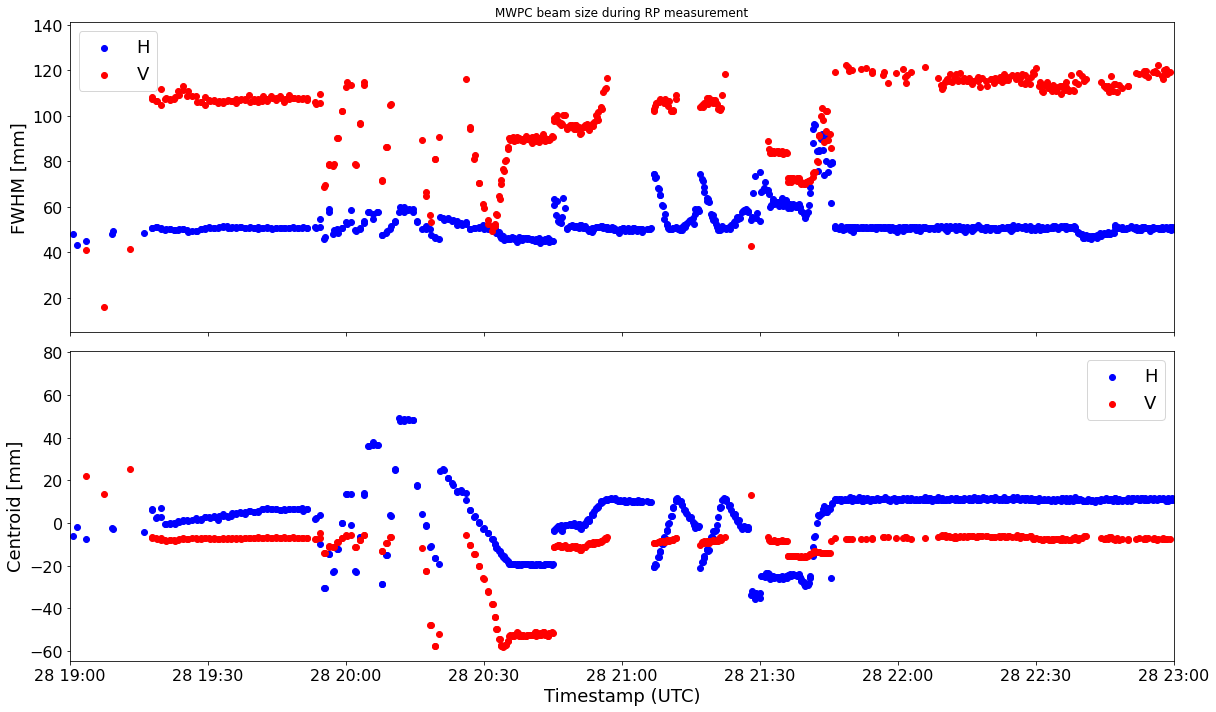

In [21]:
fig, ax = plt.subplots(2,1, figsize=(17,10), tight_layout=True, sharex=True)

ax[0].scatter(timestamp_list, fwhm_list, c="b", label="H")
ax[0].scatter(timestamp_listV, fwhm_listV, c="r", label="V")

ax[1].scatter(timestamp_list, center_list, c="b", label="H")
ax[1].scatter(timestamp_listV, center_listV, c="r", label="V")

ax[0].legend()
ax[0].set_ylabel("FWHM [mm]")
ax[0].set_title("MWPC beam size during RP measurement")

ax[1].legend()
ax[1].set_ylabel("Centroid [mm]")
ax[1].set_xlabel("Timestamp (UTC)")

ax[0].set_xlim(pd.to_datetime('2023-10-28 19:00:00.00'), pd.to_datetime('2023-10-28 23:00:00.00'))

# Example of spill time profile on gas scintillator and related duty cycle value

In [22]:
# Time in UTC
start = "2023-10-28 18:00:00.000"
end = "2023-10-29 23:00:00.000"
selector = "CPS.USER.MD3"

data = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(start).endTime(end).entity().parameter("BXSCINT_1000/Acquisition").build().toPandas()
data["timestamp"] = pd.to_datetime(data['acqStamp'], unit='ns')

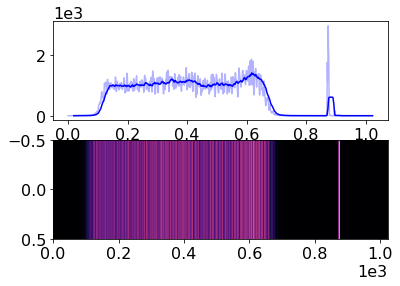

In [23]:
signal_1000 = data["countArray"]
fifoFreq = 1000 # Look at the FESA to find this value

nbOfSamples = len(signal_1000.iloc[-1]["elements"])
integrationDuration = nbOfSamples*(1/fifoFreq)*1000 # in ms

fig, ax = plt.subplots(2,1)

t = np.arange(0, integrationDuration, integrationDuration / nbOfSamples)# time in ms
d = {'t': t, 'signal_1000': signal_1000.iloc[-1]["elements"],}
df = pd.DataFrame(data=d)

ax[0].plot(df.t, df.signal_1000, color="b", alpha=0.3, label="Raw BXSCINT 1000")

window = 20
df2 = df.rolling(window=window).mean()
ax[0].plot(df.t, df2.signal_1000, color="b", alpha=1., label=f"rolling mean window = {window}")

ax[1].imshow(np.reshape(signal_1000.iloc[-1]["elements"], (1, nbOfSamples)), cmap="magma", aspect='auto', interpolation="none")

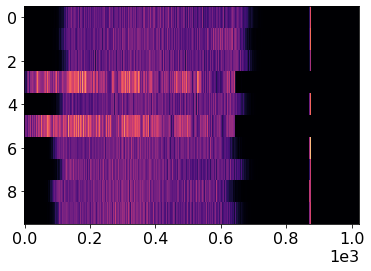

In [24]:
# Waterfall of the 10 last shots
heatmap = signal_1000.apply(lambda x: x['elements'])
fig, ax = plt.subplots()
ax.imshow(np.vstack(heatmap[:10]), cmap="magma", aspect='auto', interpolation="none")

# Energy time series

In [ ]:
# Time in UTC
start = "2023-10-28 18:00:00.000"
end = "2023-10-29 18:30:00.000"
selector = "CPS.USER.MD3"

data = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(start).endTime(end).entity().parameter("PR.BMEAS-B-ST/CycleSamples").build().toPandas()
data["timestamp"] = pd.to_datetime(data['acqStamp'], unit='ns')

In [ ]:
data.keys()

In [ ]:
data["bfield"]=  data.samples.apply(lambda x: x["elements"])
# Add a new column 'bfield_ft' handling potential IndexError
data["bfield_ft"] = data.samples.apply(lambda x: x["elements"][1500] if len(x["elements"]) > 1500 else None)

In [ ]:
fig, ax = plt.subplots()
ax.plot(data[data.selector == "CPS.USER.MD3"].bfield.iloc[0])
ax.axvline(1500)

In [ ]:
fig, ax = plt.subplots(tight_layout=True, figsize=(12,5))
data.sort_values(by="timestamp", inplace=True)
data_md = data[data.selector == "CPS.USER.MD3"]
ax.plot(data_md.timestamp, data_md.bfield_ft)

In [ ]:
def ekin_brho_from_bfield(bfield):
    Ekin = (193.737692/208)*(np.sqrt(((1/((3.3356/(70.0789*54)*10000)/bfield))/193.737692)**2+1)-1)
    rho = 70.0789
    Brho = rho*bfield/10000 # GeV/c
    return Ekin

data["ekin"] = data.bfield_ft.apply(lambda x: ekin_brho_from_bfield(x))

In [ ]:
fig, ax = plt.subplots(tight_layout=True, figsize=(12,5))

data_md = data[data.selector == "CPS.USER.MD3"]
ax.plot(data_md.timestamp, data_md.ekin)
ax.set_xlabel("Timestamp")
ax.set_ylabel("Kinetic Energy [GeV/u]")

# Evolution of spill frequency

In [ ]:
from datetime import datetime, timedelta
from pyspark.sql.functions import broadcast

def query_data(start_time, end_time):
    funds = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(start_time).endTime(end_time).entity().parameter("XTIM.PX.SCY-CT/Acquisition").build()
    funds_filtered = funds.select("acqStamp","cyclestamp", "USER", "lsaCycleName")

    bct =  DevicePropertyDataQuery.builder(spark).system("CMW").startTime(start_time).endTime(end_time).entity().parameter("PR.BCT-ST/CycleSamples").build()
    bct_filtered = bct.select("acqStamp", "cyclestamp", "samples")

    data = bct_filtered.join(broadcast(funds_filtered), "cyclestamp")
    return data.toPandas()

ts1 = datetime(2023, 10, 17, 8, 0, 0)
ts2 = datetime(2023, 10, 17, 10, 0, 0)

# Loop through the time range in 6-hour intervals
interval = timedelta(hours=6)
all_data = []

while ts1 < ts2:
    end_time = min(ts1 + interval, ts2)
    df = query_data(ts1, end_time)
    all_data.append(df)
    ts1 += interval

# Concatenate all DataFrames
final_data = pd.concat(all_data, ignore_index=True)
final_data.head(3)


In [ ]:
df = final_data[final_data.lsaCycleName == "IEAST_Pb_23"]
df['timestamp'] = pd.to_datetime(final_data['cyclestamp'], unit='ns')
df = df.sort_values(by="timestamp").reset_index()

def extract_element(row):
    return row.samples['elements'][700]
df['inj_int'] = df.apply(lambda row: extract_element(row), axis=1)
df['cumulative_inj_int'] = df['inj_int'].cumsum()
df.sort_values(by="cyclestamp", inplace=True)

In [ ]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(15,6), tight_layout=True)
ax.plot(df.timestamp, df.cumulative_inj_int)
ax.set_xlabel("Time [UTC]")
ax.set_ylabel("Injected PS BCT [e10 Charges]")
ax.set_title("Cumulative Pb ion intensity injected in the PS sent to East Area 2023")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
plt.xticks(rotation=0);

In [ ]:
fig, ax = plt.subplots(figsize=(13,5), tight_layout=True)
ax.plot(df.timestamp, df.cumulative_inj_int/54*1e10, lw=4, c="darkblue")
ax.set_xlabel("Time (UTC)")
ax.set_ylabel("Injected ions in the PS")
# ax.set_title("Cumulative Pb ions injected in the PS sent to East Area 2023")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
plt.xticks(rotation=0);
plt.savefig("ion_injected_ps_2023.png", facecolor='white', transparent=False, dpi = 300, bbox_inches='tight')

In [ ]:
# Convert timestamps to a readable format
df['formatted_timestamp'] = pd.to_datetime(df['timestamp'])
min_timestamp = df['formatted_timestamp'].min().strftime('%Y-%m-%d %H:%M:%S')
max_timestamp = df['formatted_timestamp'].max().strftime('%Y-%m-%d %H:%M:%S')

# Calculation for the histogram
hist_data = df['inj_int']/54*1e10

# Filter out non-positive values for the log scale plot
hist_data = hist_data[hist_data > 0]

# Create logarithmically spaced bins
min_val, max_val = np.min(hist_data), np.max(hist_data)
bin_edges = np.logspace(np.log10(min_val), np.log10(max_val), 1000)

# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6), tight_layout=True)

# Plot on the first axis with log scale
ax1.hist(hist_data, bins=bin_edges)
ax1.set_xscale('log')  # Set x-axis to log scale
ax1.set_xlabel("Injected ions in the PS")
ax1.set_title(f"HEARTS 2023 Run\n{min_timestamp}\n{max_timestamp}")

# Plot on the second axis - zoomed scale
ax2.hist(df['inj_int']/54*1e10, bins=200, range=(0.65e9, 0.9e9))
ax2.set_xlabel("Injected ions in the PS (Zoomed)")
ax2.set_title(f"Zoomed View\n{min_timestamp}\n{max_timestamp}")

plt.savefig("ion_injected_ps_2023_combined.png", facecolor='white', transparent=False, dpi=300, bbox_inches='tight')


In [ ]:
# Filter and preprocess the data
df = final_data[final_data.lsaCycleName == "IEAST_Pb_23"]
df['timestamp'] = pd.to_datetime(df['cyclestamp'], unit='ns')
df = df.sort_values(by="timestamp").reset_index(drop=True)

# Plotting the cumulative row number against timestamp
fig, ax = plt.subplots(figsize=(12,6), tight_layout=True)
ax.plot(df['timestamp'], df.index, label=f"{df.index.max()} cycles")
ax.set_xlabel("Time [UTC]")
ax.set_ylabel("Cumulative Number of Cycles/Spills")
ax.set_title("Cumulative Number of Pb ions Cycles sent to CHARM")

ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.xticks(rotation=0);

In [ ]:
# Convert the timestamp column to pandas datetime, if not already
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Calculate the difference in time between successive timestamps
df['time_diff'] = df['timestamp'].diff()

# Convert time differences to seconds
df['time_diff_seconds'] = df['time_diff'].dt.total_seconds()

# Filter out time differences larger than 1 hour (3600 seconds)
df_filtered = df[df['time_diff_seconds'] <= 100]

# Drop rows with NaN values (like the first row)
df_filtered = df_filtered.dropna()

# Plot 1: Histogram of the time differences (excluding differences > 1 hour)
plt.figure(figsize=(10, 6))
plt.hist(df_filtered['time_diff_seconds'], bins=50, alpha=0.7, color='blue')
plt.title(f'Histogram of Time Differences\n{datetime(2023, 10, 17, 8, 0,)}\n{datetime(2023, 11, 1, 8, 0, 0)}')
plt.xlabel('Time Difference between HEARTS cycle [s]')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot 2: Time Difference as a Function of Timestamps (excluding differences > 1 hour)
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(df_filtered['timestamp'], df_filtered['time_diff_seconds'], marker='o', linestyle='', color='red')
ax.set_title(f'HEARTS 2023 run\n{datetime(2023, 10, 17, 8, 0,)}\n{datetime(2023, 11, 1, 8, 0, 0)}')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Time Difference between HEARTS cycle [s]')
ax.grid(True)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
plt.xticks(rotation=0);
# plt.show()


In [ ]:
# Convert the timestamp column to pandas datetime, if not already
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Calculate the difference in time between successive timestamps
df['time_diff'] = df['timestamp'].diff()

# Convert time differences to seconds
df['time_diff_seconds'] = df['time_diff'].dt.total_seconds()

# Filter out time differences larger than 1 hour (3600 seconds)
df_filtered = df

# Drop rows with NaN values (like the first row)
df_filtered = df_filtered.dropna()

# Plot 2: Time Difference as a Function of Timestamps (excluding differences > 1 hour)
fig, ax = plt.subplots(figsize=(35, 6))
ax.plot(df_filtered['timestamp'], df_filtered['time_diff_seconds'], marker='o', linestyle='-')
ax.set_title(f'HEARTS 2023 run\n{datetime(2023, 10, 17, 8, 0,)}\n{datetime(2023, 11, 1, 8, 0, 0)}')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Time Difference between HEARTS cycle [s]')
ax.grid(True)

ax.set_ylim(0,100)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
plt.xticks(rotation=0);



In [ ]:
funds = DevicePropertyDataQuery.builder(spark).system("CMW").startTime('2023-10-17 08:00:00.000000').endTime('2023-10-18 10:00:00.000000').entity().parameter("XTIM.PX.SCY-CT/Acquisition").build().toPandas()
funds["timestamp"] = pd.to_datetime(funds["acqStamp"] / 1000000000, unit='s')
funds.sort_values(by="timestamp", inplace=True)

In [ ]:
fig, ax = plt.subplots(figsize=(15,6), tight_layout=True)

funds_filtered = funds[funds.SUPERCYCLE_NB == 1].dropna()

ax2 = ax.twinx()
ax2.plot(funds_filtered.timestamp, funds_filtered.SUPERCYCLE_NB, marker='o', ls='', label="New Supercycle", c="darkred")
ax2.plot(funds.timestamp, funds.SUPERCYCLE_NB, label="Supercycle number", c="orange")
ax2.legend(loc="upper left")

ax.set_title(f'HEARTS 2023 run')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Time Difference between HEARTS cycle [s]')

ax2.set_ylabel('Supercycle number [ ]')

ax.legend()

In [ ]:
# Identify resets (where both SUPERCYCLE_NB == 1 and CYCLE_NB == 1) and create a cycle identifier
resets = (funds['SUPERCYCLE_NB'] == 1) & (funds['CYCLE_NB'] == 1)
funds['cycle_id'] = resets.cumsum()

# Mark rows where lsaCycleName is 'IEAST_Pb_23'
funds['is_IEAST_Pb_23'] = funds['lsaCycleName'] == 'IEAST_Pb_23'

# Group by 'cycle_id' and count the occurrences of 'IEAST_Pb_23'
counts_per_cycle = funds.groupby('cycle_id')['is_IEAST_Pb_23'].sum()


In [ ]:
# Convert 'timestamp' to datetime if it's not already
funds['timestamp'] = pd.to_datetime(funds['timestamp'])

# Step 1: Calculate start timestamp of each cycle
funds['cycle_start'] = funds.groupby('cycle_id')['timestamp'].transform('min')

# Calculate time difference in minutes between resets
funds['cycle_duration'] = funds.groupby('cycle_id')['timestamp'].transform(lambda x: (x.max() - x.min()).total_seconds() / 60)

# Step 2: Calculate sum of 'is_IEAST_Pb_23' and total duration for each cycle
cycle_summary = funds.groupby('cycle_id').agg(
    occurrences_of_IEAST_Pb_23=('is_IEAST_Pb_23', 'sum'),
    cycle_duration=('cycle_duration', 'first'),  # since all values are the same within a group
    cycle_start=('cycle_start', 'first')  # to keep track of the cycle start time for plotting
)

# Calculate the average number of 'is_IEAST_Pb_23' occurrences per minute for each cycle
cycle_summary['avg_occurrences_per_minute'] = cycle_summary['occurrences_of_IEAST_Pb_23'] / cycle_summary['cycle_duration']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(cycle_summary['cycle_start'], cycle_summary['avg_occurrences_per_minute'], marker='o', linestyle='-')
plt.xlabel('Timestamp')
plt.ylabel('Average Occurrences of IEAST_Pb_23 per Minute')
plt.title('Average Occurrences of IEAST_Pb_23 per Minute Over Time')

for t in funds_filtered.timestamp:
    plt.axvline(x=t, linestyle='-', color='darkred')


plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
timestamps_lhc = pd.DataFrame(funds[funds.BEAM_TO_LHC==True].timestamp, columns=['timestamp'])
def check_timestamp_in_cycle(row):
    cycle_end = row['cycle_start'] + pd.Timedelta(minutes=row['cycle_duration'])
    return any((timestamps_lhc['timestamp'] >= row['cycle_start']) & (timestamps_lhc['timestamp'] <= cycle_end))

# Apply the function to create the new column
cycle_summary['lhc_in_during_cycle'] = cycle_summary.apply(check_timestamp_in_cycle, axis=1)

In [ ]:
plt.figure(figsize=(10, 6), tight_layout=True)

# Flags to track if the label has been used
label_used_true = False
label_used_false = False

# Plot horizontal lines for each cycle
for idx, row in cycle_summary.iterrows():
    # Set the color based on the 'lhc_in_during_cycle' value
    color = 'red' if row['lhc_in_during_cycle'] else 'blue'
    
    # Decide the label based on whether it's been used before
    if row['lhc_in_during_cycle'] and not label_used_true:
        label = 'LHC in cycle'
        label_used_true = True
    elif not row['lhc_in_during_cycle'] and not label_used_false:
        label = 'LHC not in cycle'
        label_used_false = True
    else:
        label = None  # No label if it's already been used

    plt.hlines(y=row['avg_occurrences_per_minute'], xmin=row['cycle_start'], xmax=row['cycle_start'] + pd.Timedelta(minutes=row['cycle_duration']), color=color, lw=5, label=label)

plt.xlabel('Timestamp')
plt.ylabel('Spill per min')
plt.legend(loc="upper left")
plt.title('Cycle Summary')
plt.tight_layout()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
